# Noise2Noise : Apprendre la restitution d'images sans données propres - Application avec une architecture U-Net

### Connection drive

Dans un premier temps, connectez-vous au drive pour accéder au dataset :

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importation des librairies pytorch

In [ ]:
import torch
from torch import optim
from torch import Tensor
from torch import nn
from torch.nn import functional as F


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Importation des données

Téléchargement de nos données provenant du dataset [Kaggle](https://www.kaggle.com/datasets/mehrdadkianiosh/noisy-images?resource=download). 

Le dataset est composé de deux fichiers : un fichier `train_data.pkl`contenant 50000 paires d'images bruitées et un fichier `val_data.pkl` contenant 1000 paires d'images bruitées.

Le dataset provient d'un challenge Kaggle, il n'y a donc pas de `test set` disponible. Nous testerons directement notre modèle sur le `validation set`.

Nous utilisons ici le fichier `augmented_train_data.pkl` que nous avons généré grâce au au jupyter notebook `Data_augmentation.ipynb`. Il contient 150000 paires d'images bruitées, soit les 50000 paires d'images bruitées du fichier `train_data.pkl` et 100000 paires d'images bruitées qui sont des flips horizontaux et verticaux 180° des 50000 paires d'images initiales.

In [ ]:
# import data
noisy_imgs_1 , noisy_imgs_2 = torch.load('/content/drive/MyDrive/ComputerVision/dataset/color_augmented_train_data_1.pkl')
noisy_imgs , clean_imgs = torch.load('/content/drive/MyDrive/ComputerVision/dataset/val_data.pkl')

print(noisy_imgs_1.shape)
print(noisy_imgs_2.shape)
print(noisy_imgs.shape)

# normalized data between 0 and 1 (because some torch function are optimized for inputs between 0 & 1)
# noisy_imgs_1 = noisy_imgs_1/255 (we don't normalized here the images from the augmented_train_data.pkl file because it has already been normalized during data_augmentation)
# noisy_imgs_2 = noisy_imgs_2/255
noisy_imgs = noisy_imgs/255
clean_imgs = clean_imgs/255

torch.Size([150000, 3, 32, 32])


AttributeError: ignored

time: 1min 11s (started: 2023-03-28 21:14:09 +00:00)


**Visualisation de notre dataset**

Importez la librairie matplotlib pour visualiser nos données :

In [ ]:
from matplotlib import pyplot as plt

Utilisation de `torch.permute` pour avoir une vue du tenseur d'origine :



Text(0.5, 1.0, 'Example of a clean_imgs from the validation set')

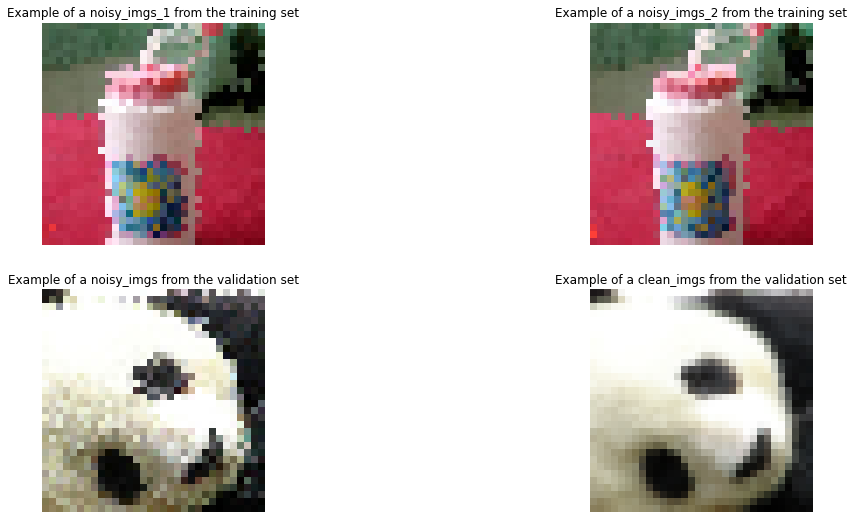

In [ ]:
# create figure
fig = plt.figure(figsize=(18, 9))
    
# setting values to rows and column variables
rows = 2
columns = 2

# adds a subplot
fig.add_subplot(rows, columns, 1)

# showing image
plt.imshow(noisy_imgs_1[7].cpu().permute(1,2,0))
plt.axis('off')
plt.title("Example of a noisy_imgs_1 from the training set")

# adds a subplot
fig.add_subplot(rows, columns, 2)
    
# showing image
plt.imshow(noisy_imgs_2[7].cpu().permute(1,2,0))
plt.axis('off')
plt.title("Example of a noisy_imgs_2 from the training set")
      
# adds a subplot 
fig.add_subplot(rows, columns, 3)
      
# showing image
plt.imshow(noisy_imgs[13].cpu().permute(1,2,0))
plt.axis('off')
plt.title("Example of a noisy_imgs from the validation set")

# adds a subplot 
fig.add_subplot(rows, columns, 4)

# showing image
plt.imshow(clean_imgs[13].cpu().permute(1,2,0))
plt.axis('off')
plt.title("Example of a clean_imgs from the validation set")

### Calcul du PSNR avant entraînement de notre modèle

Pour évaluer nos modèles, nous utiliserons la mesure du **PSNR**, exprimée en décibel (dB).

Le PSNR permet de quantifier la performance des modèles en mesurant la qualité de reconstruction de l'image compressée par rapport à l'image originale.

Pour pouvoir étudier si notre modèle est performant, nous pouvons comparer le PSNR du validation set qui calculera le PSNR entre notre `image bruitée` et notre `clean image`, avec le PSNR après entraînement du modèle qui calculera le PSNR entre notre `predicted image` et notre `clean image`.

En conséquence, si nous obtenons un PSNR plus élevé après notre modèle, cela signifie que notre signal et donc le traitement de restauration ou d'amélioration sont meilleurs. 

In [ ]:
def psnr(denoised , ground_truth):
# Peak Signal to Noise Ratio : denoised and ground_truth have values between 0 and 1
  mse = torch.mean((denoised - ground_truth) ** 2)
  return -10 * torch.log10(mse + 10**-8)

sum = 0
nb_img = noisy_imgs.size(0)
psnr_list = []

for i in range(nb_img):
  psnr_list.append(psnr(noisy_imgs[i].cpu(), clean_imgs[i].cpu()).item())
    
for j in range(nb_img):
  sum = sum + psnr_list[j]

mean_psnr = sum/nb_img

print("PSNR mean : " + str(mean_psnr) + " dB")

PSNR mean : 20.723881644248962 dB


Nous obtenons un PSNR moyen de 20.72 dB pour notre validation set. Implémentons notre modèle et comparons notre PNSR final à celui-ci.

## Architecture U-Net

Nous implémentons une structure similaire au U-Network :

In [ ]:
# network architecture
class Network(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        pass
        
        self.conv3_32 = nn.Conv2d(3, 32, kernel_size=3)
        self.bn32 = nn.BatchNorm2d(32)
        self.conv32_64 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn64_1 = nn.BatchNorm2d(64)
        ## tests for replace conv32_64 and bn64_1:
        # self.conv64_64_A = nn.Conv2d(64, 64, kernel_size=2, stride = 2)  # ----> H = 15
        # self.bn64_1_A = nn.BatchNorm2d(64)
        # self.conv64_64_B = nn.Conv2d(64, 64, kernel_size=3, stride = 2)  # ----> H = 7
        # self.bn64_1_B = nn.BatchNorm2d(64)
        # self.conv64_64_C = nn.Conv2d(64, 64, kernel_size=2) # -----> H = 6
        # self.bn64_1_C = nn.BatchNorm2d(64)
        # self.conv64_64_D = nn.Conv2d(64, 64, kernel_size=3)
        # self.bn64_1_D = nn.BatchNorm2d(64)
        # self.conv64_64_E = nn.Conv2d(64, 64, kernel_size=3)
        # self.bn64_1_E = nn.BatchNorm2d(64)
        # self.conv64_64_F = nn.Conv2d(64, 64, kernel_size=3)
        # self.bn64_1_F = nn.BatchNorm2d(64)
        # self.conv64_64_G = nn.Conv2d(64, 64, kernel_size=3)
        # self.bn64_1_G = nn.BatchNorm2d(64)
        self.pool2_2_1 = nn.AvgPool2d(kernel_size=(2,2))
        self.conv64_64 = nn.Conv2d(64, 64, kernel_size=3)
        self.bn64_2 = nn.BatchNorm2d(64)
        # self.conv64_64_A = nn.Conv2d(64, 64, kernel_size=3)
        # self.bn64_2_A = nn.BatchNorm2d(64)
        # self.conv64_64_B = nn.Conv2d(64, 64, kernel_size=3)
        # self.bn64_2_B = nn.BatchNorm2d(64)
        # self.conv64_64_C = nn.Conv2d(64, 64, kernel_size=3)
        # self.bn64_2_C = nn.BatchNorm2d(64)
        self.pool2_2_2 = nn.AvgPool2d(kernel_size=(2,2))
        # self.conv64_64_2 = nn.Conv2d(64, 64, kernel_size=3)
        # self.bn64_3 = nn.BatchNorm2d(64)
        # self.pool2_2_3 = nn.AvgPool2d(kernel_size=(2,2))
        # self.upsample2_0 = nn.Upsample(scale_factor=2)
        # self.t_conv64_64_0 = nn.ConvTranspose2d(64, 64, kernel_size=3)
        # self.bn64_4 = nn.BatchNorm2d(64)
        self.upsample2_1 = nn.Upsample(scale_factor=2)
        self.t_conv64_64 = nn.ConvTranspose2d(64, 64, kernel_size=3)
        # self.bn64_5 = nn.BatchNorm2d(64)
        # concatenate with output of pool2_2_1
        self.upsample2_2 = nn.Upsample(scale_factor=2)
        self.t_conv128_64 = nn.ConvTranspose2d(128, 64, kernel_size=3)
        # self.bn64_6 = nn.BatchNorm2d(64)
        self.t_conv64_32 = nn.ConvTranspose2d(64, 32, kernel_size=3)
        # self.bn64_7 = nn.BatchNorm2d(32)
        # concatenate with input
        self.conv35_32 = nn.Conv2d(35, 32, kernel_size=3)
        self.t_conv32_3 = nn.ConvTranspose2d(32, 3, kernel_size=3)
        
    
    def forward(self, x):
        x0 = x
        x = F.relu(self.conv3_32(x))
        # x = self.bn32(x)
        x = F.relu(self.conv32_64(x))
        # x = self.bn64_1(x)
        x1 = F.relu(self.pool2_2_1(x))
        # print('pool2_2_1:', x1.shape)
        # x = F.relu(self.conv64_64_A(x))
        # x = self.bn64_1_A(x)
        # print('conv64_64_A :', x.shape)
        # x = F.relu(self.conv64_64_B(x))
        # x = self.bn64_1_B(x)
        # print('conv64_64_B :', x.shape)
        # x = F.relu(self.conv64_64_C(x))
        # x = self.bn64_1_C(x)
        # print('conv64_64_C :', x.shape)
        # x = F.relu(self.conv64_64_D(x))
        # x = self.bn64_1_D(x)
        # x = F.relu(self.conv32_64(x))
        # x = self.bn64_1_E(x)
        # x = F.relu(self.conv64_64_F(x))
        # x = self.bn64_1_F(x)
        # x = F.relu(self.conv64_64_G(x))
        # x1 = self.bn64_1_G(x)
        x = F.relu(self.conv64_64(x1))
        # x = self.bn64_2(x)
        # print('conv64_64:', x.shape)
        # x = F.relu(self.conv64_64_A(x))
        # x = self.bn64_2_A(x)
        # x = F.relu(self.conv64_64_B(x))
        # x = self.bn64_2_B(x)
        # x = F.relu(self.conv64_64_C(x))
        # x = self.bn64_2_C(x)
        x = F.relu(self.pool2_2_2(x))
        # print('pool2_2_2:', x.shape)
        # x = F.relu(self.conv64_64_2(x2))
        # x = self.bn64_3(x)
        # x = F.relu(self.pool2_2_3(x))
        # x = F.relu(self.upsample2_0(x))
        # x = F.relu(self.t_conv64_64_0(x))
        # x = self.bn64_4(x)
        # x = torch.cat((x, x2), dim=1)
        x = F.relu(self.upsample2_1(x))
        # print('upsample2_1:', x.shape)
        x = F.relu(self.t_conv64_64(x))
        # x = self.bn64_5(x)
        # print('t_conv64_64:', x.shape)
        x = torch.cat((x, x1), dim=1)
        x = F.relu(self.upsample2_2(x))
        x = F.relu(self.t_conv128_64(x))
        #x = self.bn64_6(x)
        x = F.relu(self.t_conv64_32(x))
        #x = self.bn64_7(x)
        x = torch.cat((x, x0), dim=1)
        x = F.relu(self.conv35_32(x))
        x = F.relu(self.t_conv32_3(x))

        return x

In [ ]:
class Model(nn.Module):
    def __init__(self) -> None:
        # instantiation of the model, loss function and optimizer
        super().__init__()
        self.autoencoder = Network().to(device)
        self.criterion = nn.MSELoss().to(device)
        self.optimizer = torch.optim.Adam(self.autoencoder.parameters(), lr = 1e-3)
        self.weight_initialization()
        pass

    def weight_initialization(self):
        for mod in self.modules():
          if isinstance(mod, nn.Conv2d):
            nn.init.kaiming_normal_(mod.weight.data)
            mod.bias.data.zero_()

    def load_last_trained_model (self) :
    # to load the parameters saved in parameters_models_UNet.pth into the model
    # self.load_state_dict(torch.load(path, map_location=torch.device(device)))        
        saved_model_path = "/content/drive/MyDrive/DeepL_Project/parameters_models_UNet.pth"
        model = torch.load(saved_model_path)
        self.load_state_dict(model)
        self.to(device)
        pass
  
    def save_parameters_Model(self) :
        # to save our parameters in parameters_models.pth
        torch.save(self.state_dict(), '/content/drive/MyDrive/DeepL_Project/parameters_models_UNet.pth')
        pass 

    def train(self, train_imgs_1, train_imgs_2, nb_epochs) -> None:
        # train_imgs_1 : tensor of size (N, C, H, W) with a noisy version of the images     
        # train_imgs_2 : tensor of size (N, C, H, W) with another noisy version of the same images, which only differs from the input by their noise
        mini_batch_size = 100
        loss_list = []

        for e in range(nb_epochs):
            acc_loss = 0
            for b in range(0, train_imgs_1.size(0), mini_batch_size):
                output = self.autoencoder(train_imgs_1.narrow(0, b, mini_batch_size).to(device))
                loss = self.criterion(output, train_imgs_2.narrow(0, b, mini_batch_size).to(device))
                acc_loss = acc_loss + loss.item()
                # self.autoencoder.zero_grad()
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            print(e, acc_loss)

            print("Loss : ", loss.item())
            loss_list.append(loss.item())
        return loss_list
        pass

    def prediction(self, val_input) -> torch.Tensor:
        # val_input : tensor of size (N1, C, H, W) that has to be denoised by the trained network
        # returns a tensor of the size (N1, C, H, W)
        return self.autoencoder(val_input)
        pass

torch.cuda.empty_cache()

**Entraînement de notre modèle**

Installez la librairie `ipython-autotime` afin de pouvoir indiquer le temps d'exécution de notre modèle :

In [ ]:
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.2 MB/s eta 0:00:00
time: 500 µs (started: 2023-03-28 20:42:19 +00:00)


In [ ]:
m = Model()

time: 5.05 s (started: 2023-03-28 20:42:19 +00:00)


Téléchargez le dernier train modèle sauvegardé afin de ne pas réexécuter le modèle par la suite : 

In [ ]:
m.load_last_trained_model()

time: 11.9 ms (started: 2023-03-02 13:53:34 +00:00)




---



*Les deux cellules suivantes sont à exécuter uniquement si vous voulez entraîner d'autres architectures de réseaux.*

Exécuter la cellule uniquement si vous voulez entraîné un nouveau réseau :

In [ ]:
loss_list = m.train(noisy_imgs_1.float(), noisy_imgs_2.float(), nb_epochs = 20)
torch.cuda.empty_cache()

0 28.71710048429668
Loss :  0.01621999777853489
1 22.294977095909417
Loss :  0.01591169461607933
2 22.066511172801256
Loss :  0.015798410400748253
3 21.954345725476742
Loss :  0.01575249619781971
4 21.882210147567093
Loss :  0.015703249722719193
5 21.829642846249044
Loss :  0.015688275918364525
6 21.78752806223929
Loss :  0.015669921413064003
7 21.75222782790661
Loss :  0.01565595157444477
8 21.721050216816366
Loss :  0.01564188115298748
9 21.69589993543923
Loss :  0.015631018206477165
10 21.67472630366683
Loss :  0.015609214082360268
11 21.65555463731289
Loss :  0.015582313761115074
12 21.63697739969939
Loss :  0.01557968370616436
13 21.622098026797175
Loss :  0.015577434562146664
14 21.60864059161395
Loss :  0.015568765811622143
15 21.59776421636343
Loss :  0.015565615147352219
16 21.588561272248626
Loss :  0.015557381324470043
17 21.580487111583352
Loss :  0.015542167238891125
18 21.57275367807597
Loss :  0.015530304983258247
19 21.566596994176507
Loss :  0.015521611087024212
time: 

Le fichier `parameters_models_UNet.pth` permet de sauvegarder les paramètres du training pour garder en mémoire les performances des différentes architectures réseaux (pas besoin de relancer de training pour une architecture qui a déjà été lancée ! ). Dans le fichier `parameters_models_UNet.pth` se trouve uniquement les paramètres de notre modèle sélectionné. Si vous voulez entraîner d'autres réseaux et les sauvegarder dans le fichier, exécutez la cellule suivante :


In [ ]:
m.save_parameters_Model()

time: 15.8 ms (started: 2023-03-02 13:53:34 +00:00)


**Visualition de la `loss function` en fonction du nombre d'epochs**

Importez la libraire numpy :

In [ ]:
import numpy as np

time: 564 µs (started: 2023-03-28 20:55:59 +00:00)


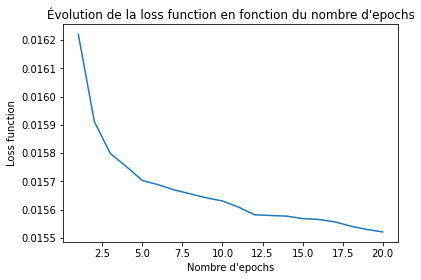

time: 216 ms (started: 2023-03-28 20:55:59 +00:00)


In [ ]:
# create a numpy array manually to have our number of epochs
epochs = np.arange(1,21)

# create figure
plt.plot(epochs,loss_list)

# add titles
plt.title("Évolution de la loss function en fonction du nombre d'epochs")
plt.xlabel("Nombre d'epochs")
plt.ylabel('Loss function')

# showing figure
plt.show()

Nous observons que notre `loss function` décroît bien en fonction du nombre d'epochs.

**Déclaration et visualation de notre `predicted image`** 

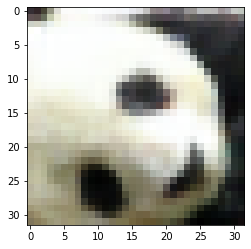

time: 264 ms (started: 2023-03-28 20:56:00 +00:00)


In [ ]:
predicted_img = m.prediction(noisy_imgs.float().to(device))

with torch.no_grad():
  plt.imshow(predicted_img[13].cpu().permute(1,2,0))

**Entraînement d'un deuxième U-NET avec déclaration et visualation de notre deuxième `predicted image`** 

Nous aimerions voir si notre PSNR s'améliore en procédant à une deuxième application du réseau à partir de notre `predicted image` obtenue lors de la première application du réseau :

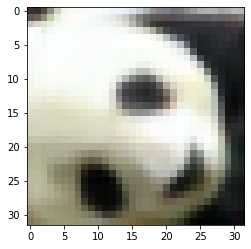

time: 262 ms (started: 2023-03-28 20:56:00 +00:00)


In [ ]:
predicted_img_2 = m.prediction(predicted_img.float().to(device))

with torch.no_grad():
  plt.imshow(predicted_img_2[13].cpu().permute(1,2,0))

### Visualisation finale des données du `validation set`

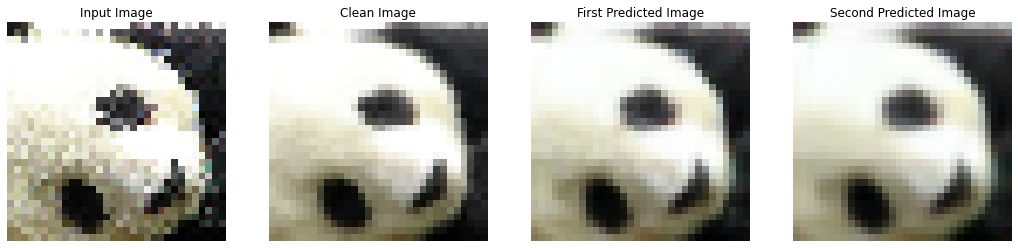

time: 432 ms (started: 2023-03-28 20:56:00 +00:00)


In [ ]:
with torch.no_grad():

  # create figure
  fig = plt.figure(figsize=(18, 9))
    
  # setting values to rows and column variables
  rows = 1
  columns = 4

  # adds a subplot 
  fig.add_subplot(rows, columns, 1)

  # showing image
  plt.imshow(noisy_imgs[13].cpu().permute(1,2,0))
  plt.axis('off')
  plt.title("Input Image")

  # adds a subplot 
  fig.add_subplot(rows, columns, 2)
    
  # showing image
  plt.imshow(clean_imgs[13].cpu().permute(1,2,0))
  plt.axis('off')
  plt.title("Clean Image")
      
  # adds a subplot 
  fig.add_subplot(rows, columns, 3)
      
  # showing image
  plt.imshow(predicted_img[13].cpu().permute(1,2,0))
  plt.axis('off')
  plt.title("First Predicted Image")

  # adds a subplot 
  fig.add_subplot(rows, columns, 4)
      
  # showing image
  plt.imshow(predicted_img_2[13].cpu().permute(1,2,0))
  plt.axis('off')
  plt.title("Second Predicted Image")

Nous remarquons que notre `predicted image` est très proche visuellement de la `clean image`.

Il est important de souligner que notre jeu de données est en base résolution pour permettre de réduire les temps de calculs pouvant être trop volumineux en haute réoslution. Notre `clean image` et `predicted image` restent donc floues à l'oeil nu.

### Calcul du PSNR après entraînement de notre modèle

In [ ]:
def psnr(denoised , ground_truth):
# Peak Signal to Noise Ratio: denoised and grounḋ_truth have values between 0 and 1
  mse = torch.mean((denoised - ground_truth) ** 2)
  return -10 * torch.log10(mse + 10**-8)

sum = 0
nb_img = predicted_img.size(0)
psnr_list = []

for i in range(nb_img):
  psnr_list.append(psnr(predicted_img[i].cpu(), clean_imgs[i].cpu()).item())
    
for j in range(nb_img):
  sum = sum + psnr_list[j]

mean_psnr = sum/nb_img

print("PSNR mean with one U-Net : " + str(mean_psnr) + " dB")


sum = 0
nb_img = predicted_img_2.size(0)
psnr_list = []

for i in range(nb_img):
  psnr_list.append(psnr(predicted_img_2[i].cpu(), clean_imgs[i].cpu()).item())
    
for j in range(nb_img):
  sum = sum + psnr_list[j]

mean_psnr = sum/nb_img

print("PSNR mean with two U-Net : " + str(mean_psnr) + " dB")

# with 8 batch normalization, PSNR = 24.86
# with 4 batch normalization (down sampling), PSNR = 25.08 ------> not to much batch normalization
# however, batch normalization lowers massively the loss
# with one less layer and 4 batch normalization, PSNR = 25.12
# more channels, PSNR = 25.04
# less channels, slightly higher loss at beginning, PSNR = 24.69
# another less layer + very low channels at end, slightly higher loss at beginning, PSNR = 23.42 ------> keep current number of layers (2 concatenates)
# back to an extra layer but still low nb_channels at end, highest loss up to now at beginning, PSNR = 23.52 
# back to higher nb of channels at the end, back to lower loss, PSNR = 24.93 -----> keep higher nb of channels at end + keep AvgPool
# back to AvgPool, PSNR = 25.05
# replace avgpools by simple enc_convs, PSNR = 24.47
# adding stride and changing kernel size, very high loss at beginning, PSNR = 23.63
# back to best model but with no enc-dec at the end, PSNR = 23.73
# back to final conv-deconv, PSNR = 25.02 
# current state without data augmentation, PSNR = 25.34 
# current state with data augmentation, PSNR = 25.50

# with filtered median : PSNR = 24.08
# with filtered gaussian: PSNR = 25.24 
# with filtered bilateral : PSNR = 12.42
# with filtered unsharp_masking : PSNR = 25.43
# with filtered unsharp_masking & median : PSNR = 23.02
# with filtered nagao : PSNR = 23.04

# current state with data augmentation with two U-Net, PSNR = 24.97

# current state with color data augmentation, PSNR = 25.50

PSNR mean with one U-Net : 25.50957899093628 dB
PSNR mean with two U-Net : 24.96959173965454 dB
time: 198 ms (started: 2023-03-28 20:56:01 +00:00)


Nous obtenons un PSNR moyen de 25.50 dB après l'entraînement de notre U-Net avec data augmentation et 25.34 sans data augmentation avec le fichier `train_data.pkl`.

En conséquence, nous obtenons un PSNR plus élevé après entraînement de notre modèle, cela signifie que notre signal et donc le traitement de restauration ou d'amélioration sont meilleurs. L'architecture U-Net obtient le PSNR le plus élevé par rapport aux autres modèles entraînés.



---

Nous avons également essayé d'entraîner une deuxième fois notre modèle U-Net à partir de notre `predicted image` pour obtenir une deuxième `predicted image`. Nous remarquons que le PSNR moyen obtenu (24.97 dB) est moins bon que le PSNR sur notre première `predicted image`.